### MCMC Example 2

Estimating the observational "error" from the data & conjugate priors

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numba import njit, float64, int32
from numba.experimental import jitclass
from scipy.stats import kde
import pygtc

from typing import List
Vector = List[float]

plt.rcParams['figure.dpi'] = 150

import numpy.random as rng
seed = 9812631
rng.seed(seed)
@njit
def xiN(N):
    return rng.rand(N)
@njit
def xi():
    return rng.rand()
@njit
def xiNormalN(N):
    return rng.randn(N)
@njit
def xiNormal():
    return rng.randn()

@njit
def gam(shape, scale):
    return rng.gamma(shape, scale, size=1)[0]
@njit
def gamN(shape, scale, N):
    return rng.gamma(shape, scale, size=N)

We will take the same example problem as last time, but this time instead of specifying a measurement error, we will include the measurement error as one of the parameters in the model.

We will use this as an excuse to introduce some new concepts. The first is *Gibbs sampling*, a special case of Metropolis-Hastings (MH).

As usual, we have a distribution $p(\mathbf{w})$ from which we wish to sample. 
We have seen that MH generates a jump in all components of $\mathbf{w}$ for each move. In single-component MH,
the method we used last time, we sequentially, or randomly, pick a jump in one $w_i$ at a time. In both cases, we then used acceptance/rejection to achieve detailed balance in our Markov Chain from samples proposed from the priors.

In Gibbs sampling, we will sample one of the $w_i$ at a time, but from the conditional distribution $p(w_i|\mathbf{w}_{\backslash i})$, the probability of $w_i$ conditioned on the values of the remaining variables.
For example, for three parameters at step $n$ in the chain, the algorithm would be   

\begin{align}
\mathrm{sample}\ w_1^{(n+1)}\ & \ \textrm{from}\ p(w_1 | w_2^{(n)}, w_3^{(n)}) \\
\mathrm{sample}\ w_2^{(n+1)}\ & \ \textrm{from}\ p(w_2 | w_1^{(n+1)}, w_3^{(n)}) \\
\mathrm{sample}\ w_3^{(n+1)}\ & \ \textrm{from}\ p(w_3 | w_1^{(n+1)}, w_2^{(n+1)})
\end{align}

Now, consider an MH sampling. The transition probability for any one of our Gibbs steps from $\mathbf{w}$ to $\mathbf{w}^\prime$ is $q(\mathbf{w}^\prime|\mathbf{w}) = p(w_i^\prime|\mathbf{w}_{\backslash i})$. Because we are sampling only in one component, $\mathbf{w}_{\backslash i}^\prime = \mathbf{w}_{\backslash i}$, and
$p(\mathbf{w}) = p(w_i|\mathbf{w}_{\backslash i})p(\mathbf{w}_{\backslash i})$ by the product rule. The MH acceptance probability is then
$$ \frac{p(\mathbf{w}^\prime)q(\mathbf{w}^\prime|\mathbf{w})}{p(\mathbf{w})q(\mathbf{w}|\mathbf{w}^\prime)}
 = \frac{p(w_i^\prime|\mathbf{w}_{\backslash i}^\prime)p(\mathbf{w}_{\backslash i}^\prime)p(w_i|\mathbf{w}_{\backslash i}^\prime)}{p(w_i|\mathbf{w}_{\backslash i})p(\mathbf{w}_{\backslash i})p(w_i^\prime|\mathbf{w}_{\backslash i})} = 1 $$
The MH steps in Gibbs sampling are always accepted.

To use Gibbs sampling, the conditional distributions $p(w_i|\mathbf{w}_{\backslash i})$ must be known. To that end,
we introduct the notion of *conjugate priors*.  If we have a conditional probability $p(\theta| x)$, a prior $p(\theta)$ is conjugate to it if it is from the same functional form as $p(\theta| x)$.

As a first example, consider the data $D = \left\{d_1,\dots,d_N\right\}$ with some known variance $\sigma^2$. The likelihood function for the mean $\mu$ is   

$$ p(D|\mu) = \prod_{i=1}^N p(x_i|\mu) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left\{-\frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2\right\} $$
which is the exponential of a quadratic form in $\mu$. If we choose a prior $p(\mu)$ to be a Gaussian, it will be conjugate to the likelihood, because the posterior distribution 
$$ p(\mu|D) \propto p(D|\mu)p(\mu) $$
will be the product of two exponentials of quadratics, which is an exponential of a quadratic.

Thus, taking the prior
$$ p(\mu) = \mathcal{N}(\mu| \mu_0, \sigma_0^2) $$
the posterior distibution is
$$ p(\mu|D) = \mathcal{N}(\mu|\mu_N, \sigma^2_N) $$
where
$$ 
\mu_N = \frac{\sigma^2}{N\sigma^2_0 + \sigma^2}\mu_0 + \frac{N\sigma^2_0}{N\sigma^2_0 + \sigma^2}\mu_{ML} $$
where $\mu_{ML}$ is the maximum-likelihood
$$ \mu_{ML} = \frac{1}{N}\sum_{i=1}^N x_i $$
and where
$$ \frac{1}{\sigma^2_N} = \frac{1}{\sigma_0^2} + \frac{1}{\sigma^2} $$
As $N\rightarrow0$, $\mu_N\rightarrow\mu_0$ while as $N\rightarrow\infty$, $\mu_N\rightarrow\mu_{ML}$.


Similarly, assume the mean is known, but we don't know the variance of our data $D$; this is the case for our
eclipsing exoplanet example in this notebook. Writing the precision $\lambda = \sigma^{-2}$, the likelihood function is
$$ p(D|\lambda) = \prod_{i=1}^N \mathcal{N}(x_i|\mu, \lambda^{-1}) \propto \lambda^{N/2}\exp\left\{
-\frac{\lambda}{2}\sum_{i=1}^N(x_i-\mu)^2\right\} $$
The corresponding conjugate prior should be proportional to a power of $\lambda$ times the exponential of a linear function of $\lambda$. This is the *gamma distribution*
$$ \Gamma(x|\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x} $$
which is everywhere finite if $\alpha\ge1$ and has a finite integral if $\alpha > 0$. Its mean and variance are
\begin{align}
\mathbb{E}[x] &= \frac{\alpha}{\beta} \\
\mathrm{var}[x] &= \frac{\alpha}{\beta^2}
\end{align}
If we take our prior on $\lambda$ as the gamma distribution $\Gamma(\lambda|\alpha_0,\beta_0)$, then the posterior distribution of $\lambda$ becomes
$$ p(\lambda|D) = p(D|\lambda) p(\lambda) \propto \lambda^{\alpha_0-1+N/2} \exp\left\{-\beta_0\lambda - \frac{\lambda}{2}\sum_{i=1}^N(x_i-\mu)^2\right\} $$
which is itself a gamma distribution with
\begin{align}
\alpha_N &= \alpha_0 + \frac{N}{2} \\
\beta_N &= \beta_0 + \frac{1}{2}\sum_{i=1}^N(x_i-\mu)^2
\end{align}


Turning to our exoplanet example,
If we define $n_0 = \alpha_0/2$ and $\sigma_0^2 = \beta_0/2$, then
our prior on $\sigma^{-2}$ is 
$$ p(\sigma^{-2}) = \Gamma\left(\frac{n_0}{2},\frac{n_0}{2}\sigma_0^2\right)$$
and the posterior probabilty of $\sigma^{-2}$ is
$$ p(\sigma^{-2}|D, \mathbf{w}) = \Gamma\left(\frac{n_0+N}{2}, \frac{n_0\sigma_0^2 + S(\mathbf{w})}{2}\right)$$
where 
$$ S(\mathbf{w}) = \sum_{i=1}^N \left(M_i - f(p_i, \mathbf{w})\right)^2 $$
is just the sum of squares term in the problem's likelihood function. $\sigma_0^2$ specifies the mean of $\sigma^2$ in our prior, and $n_0$ give a measure of how confident we are in that value, larger values of $n_0$ leading to a tighter prior on the variance.

As for many special functions, there are several definitions, and the one in numpy is slightly different from that used above (see the entry under Gamma Distribution in Wikipedia). Using the supplied function we can sample from 
our prior with the following code:

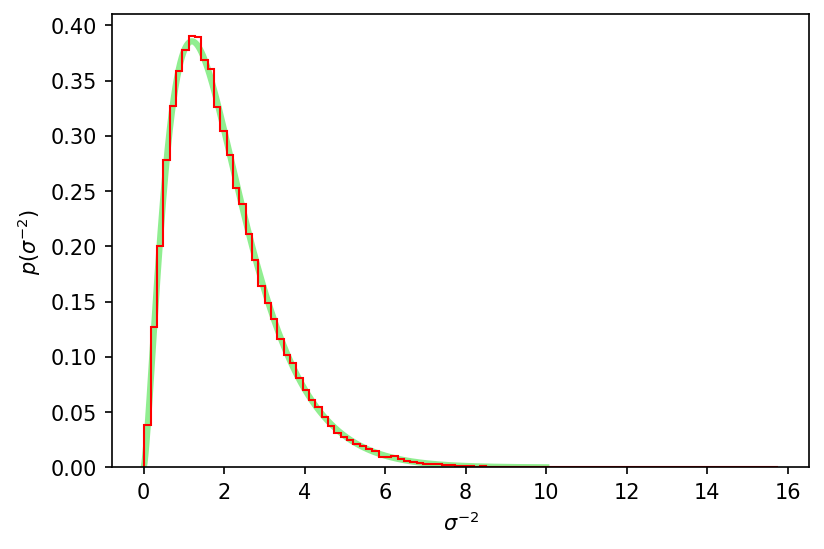

In [2]:
import scipy.special as sps  

def gamma(x, alpha, beta):
    # mean = alpha/beta
    # variance = alpha/beta**2
    return beta**alpha/sps.gamma(alpha) * x**(alpha-1) * np.exp(-beta*x)

n0 = 5
so2 = 0.5

fig, ax = plt.subplots()

# sample 1/sigma^2
x = gamN(0.5*n0, 1/(0.5*n0*so2), 100000)
count, bins, ignored = ax.hist(x, bins=100,density=True, histtype='step', color='r');

#plot gamma function
x = np.linspace(0, 10, 10000)
y = gamma(x, 0.5*n0, (0.5*n0*so2))
ax.plot(x, y, lw=3, zorder=1, color='lightgreen')

ax.set_xlabel('$\sigma^{-2}$')
ax.set_ylabel('$p(\sigma^{-2}$)');

and sampling $\sigma^2$, we have

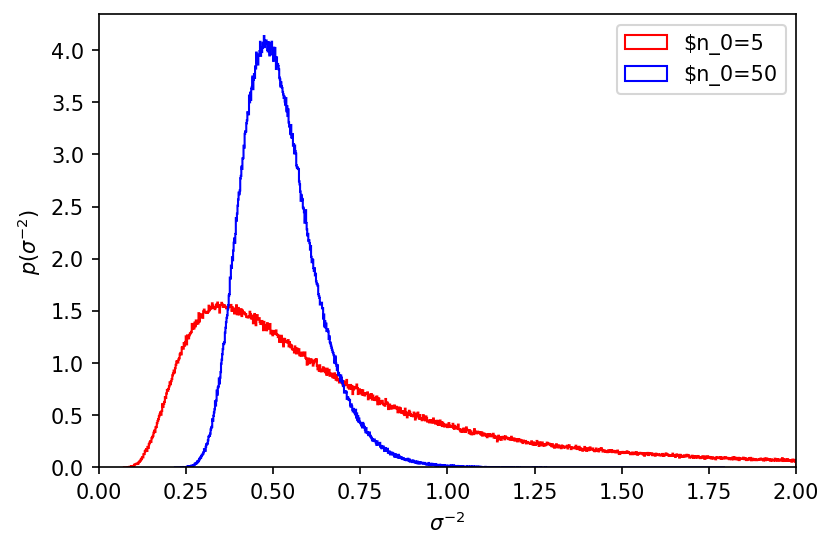

In [3]:
import scipy.special as sps  

n0 = 5
so2 = 0.5

fig, ax = plt.subplots()

# sample 1/sigma^{-2}
N = 1000000
x = np.zeros(N)
for i in range(N):
    while True:
        s = 1/gam(0.5*n0, 1/(0.5*n0*so2))
        if s < 2: break
    x[i] = s

count, bins, ignored = ax.hist(x, bins=1000,density=True, histtype='step', color='r', label='$n_0=5');

# sample 1/sigma^{-2}
n0 = 50
N = 1000000
x = np.zeros(N)
for i in range(N):
    while True:
        s = 1/gam(0.5*n0, 1/(0.5*n0*so2))
        if s < 2: break
    x[i] = s
count, bins, ignored = ax.hist(x, bins=1000,density=True, histtype='step', color='b', label='$n_0=50');

ax.set_xlim(0,2)
ax.legend()
ax.set_xlabel('$\sigma^{-2}$')
ax.set_ylabel('$p(\sigma^{-2}$)');

This, then, enables us to sample for the unknown parameter $\sigma^2$ in our MCMC using Gibbs sampling.

See the last few lines of the MCMC.run function below.

In [4]:
@njit
def modelFunction(p: np.ndarray, w: np.ndarray) -> np.ndarray :
    M, dm, dp, pe = w
    return np.where( (p>pe-dp/2) & (p<pe+dp/2), M-dm, M)


In [5]:
# Parameters for the simulated observations:
M0 = 10
dm0 = 5
dp0 = 0.2
pe0 = 0.35

# sample size:
N = 100

# variance on each observation:
sig0 = 0.75

truth = np.array([M0, dm0, dp0, pe0, sig0])

# vector of "true" parameters
w0 = np.array([M0, dm0, dp0, pe0])

data = np.zeros((N,3))
data[:,0] = np.sort(xiN(N))
data[:,1] = modelFunction(data[:,0], w0) + sig0*xiNormalN(N)
data[:,2] = np.ones(N)*sig0

wp = np.zeros_like(w0)
wp[:] = w0
wp[0] = 0
wp[1] = -dm0
foo = modelFunction(data[:,0], wp) + data[:,1]
muM0 = foo.mean()
sigM0 = np.sqrt(foo.var())

In [6]:
spec = [
    ('wRange', float64[:,:]),
    ('nParams', int32),
    ('mixParams', float64[:]),
    ('sigParams', float64[:]),
    ('chain', float64[:,:])
]

@jitclass(spec)
class MCMC:
    def __init__(self, wRange: np.ndarray, mixParams: np.ndarray, sigParams: np.ndarray):
        # Ranges in parameter values:
        self.wRange = wRange
        self.nParams = wRange.shape[0]
        self.mixParams = mixParams
        self.sigParams = sigParams
        
    def logPrior(self, w: np.ndarray) -> float :
    
        for i in range(w.shape[0]):
            if (w[i] < self.wRange[i,0]) or (w[i] > self.wRange[i,1]):
                return -np.Inf
        return 0.0
    
    def samplePrior(self) -> np.ndarray :
        w = np.zeros(self.nParams, dtype=np.float64)
        for i in range(self.nParams):
            w[i] = (wRange[i,1]-wRange[i,0])*xi() + wRange[i,0]

        return w

    def propose(self, w: np.ndarray, i) -> np.ndarray:
        nParam = w.shape[0]
        wNew = np.zeros_like(w, dtype=np.float64)
        wNew[:] = w

        # Which one should we change?
        #i = int(xi()*nParam)
        eps = self.sampleMixture(self.mixParams[0], self.mixParams[1])
        wNew[i] += (wRange[i,1]-wRange[i,0])*eps

        return wNew

    def logLikelihood(self, data: np.ndarray, w: np.ndarray, sigma2: float) -> List[np.float64]:
        """
        Log of the likelihood given the parameters
        data[:,0] = the observed phase
        data[:,1] = the observed magnitude
        data[:,2] = the reported error in the individual observations
        sigma2: the variance on each of the data points
        """
        N = data.shape[0]
        
        ss2 = np.sum( (data[:,1] - modelFunction(data[:,0],w))**2 )
        
        logl = -0.5*N*np.log(2*np.pi) - 0.5*N*np.log(sigma2) - 0.5*ss2 / sigma2

        return ss2, logl

    def run(self, Nsteps, data):

        # start off at some random w drawn from our prior distribution
        w = self.samplePrior()
        # and sigma2 from our prior
        sigma2 = 1.0/rng.gamma(0.5*self.sigParams[0], 
                               1.0/(0.5*self.sigParams[0]*self.sigParams[1]),size=1)[0]

        # Compute log prior and log likelihood
        logp = self.logPrior(w)
        sumOfSquares, logl = self.logLikelihood(data, w, sigma2)

        N = data.shape[0]
        nParam = w.shape[0] # the value of w plus its sigma and log likelihood
        self.chain = np.zeros((Nsteps, nParam + 2), dtype=np.float64)

        # count the number of successful proposals
        ngood = 0

        cnt = 0
        for i in range(Nsteps):
            for j in range(self.nParams):
                wNew = self.propose(w, j)
                logpNew = self.logPrior(wNew)

                # Only evaluate the likelihood if prior prob isn't zero
                loglNew = -np.Inf
                if logpNew != -np.Inf:
                    sumOfSquares, loglNew = self.logLikelihood(data, wNew, sigma2)
           
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
                logRatio = (logpNew + loglNew) - (logp + logl)
                logRatio = min(0.0, logRatio)

                # Acceptance/rejection
                if xi() <= np.exp(logRatio):
                    w = wNew
                    logp = logpNew
                    logl = loglNew
                    ngood += 1
            
            # Gibbs sampler for sigma^2: move is always accepted
            shape = 0.5*(self.sigParams[0] + N)
            scale = 0.5*(self.sigParams[0]*self.sigParams[1] + sumOfSquares)
            sigma2 = 1.0/gam(shape, 1.0/scale)
            
            self.chain[i, :-2] = w
            self.chain[i, -2] = np.sqrt(sigma2)
            self.chain[i, -1] = logl
                
        return ngood/(Nsteps*self.nParams)
    
    def sampleMixture(self, a, b):
        return 10.0**(a - b*np.abs(xiNormal()/np.sqrt(-np.log(xi()))))*xiNormal()

In [7]:
# Prior on parameters is uniform within these ranges
wRange = np.array([[-100,100],[0, 10], [0, 1], [0, 1]], dtype=np.float64)

# Width of distribution from which to sample proposed moves
mixParams = np.array([1.5, 6], dtype=np.float64)

# parameters for the posterior probability of the variance in the data
sigParams = np.array([5, 0.75])

# Run the chain
doit = MCMC(wRange, mixParams, sigParams)

goodFrac = doit.run(10**6, data)
print(f"\n\nAcceptance ratio: {goodFrac}")



Acceptance ratio: 0.40917775


In [8]:
def plotChain(chain, labs):
    nParams = chain.shape[1]-2
    fig, ax = plt.subplots(nParams+2, 1)
    for i in range(nParams):
        ax[i].plot(chain[:,i])
        ax[i].set_ylabel(labs[i])
    ax[-2].plot(chain[:,-2])
    ax[-2].set_ylabel('$\sigma$')
    ax[-1].plot(chain[:,-1])
    ax[-1].set_ylabel('$\log\mathcal{L}$')

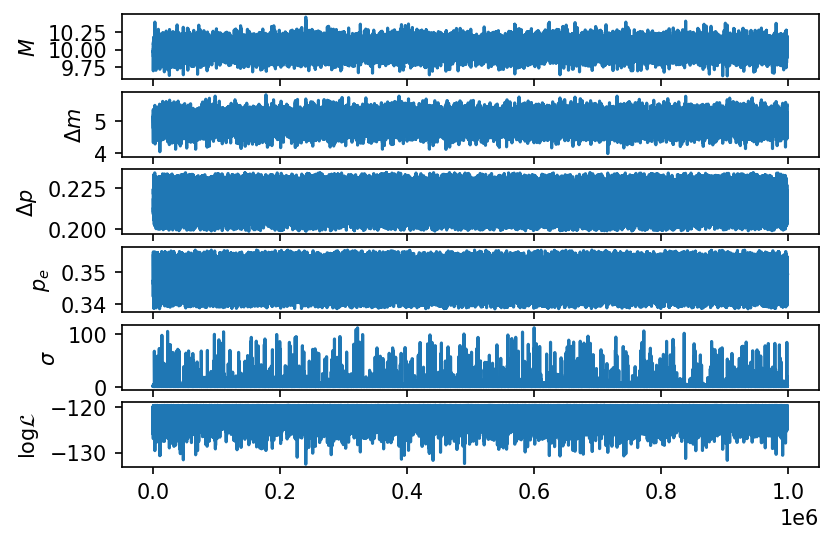

In [9]:
labs = ['$M$','$\Delta m$', '$\Delta p$', '$p_e$', '$\sigma$']
burn = 10**3
plotChain(doit.chain[burn:,:], labs)

In [10]:
# don't let several big values of sigma distort the plots...
foo = doit.chain[burn:,-2]
foo = np.where(foo>2, 2, foo)
doit.chain[burn:,-2] = foo

In [11]:
def plotSlice(samples, w0, a, b):
    M = samples[:,a]
    dm = samples[:,b]

    fig, ax = plt.subplots(2, 2)
    hts, edges, pat = ax[0,0].hist(M,bins=30, density=True, histtype='step')
    ax[0,0].set_xlim(M.min(), M.max())
    ax[0,0].plot([w0[a],w0[a]], [hts.min(),hts.max()],'r')
#    ax[0,0].plot([muM0,muM0], [hts.min(),hts.max()], 'g')

    ax[0,1].remove()

    ax[1,0].scatter(M, dm, marker='.', s=1)
    ax[1,0].set_ylim(dm.min(), dm.max())
    ax[1,0].set_xlim(M.min(), M.max())
    ax[1,0].set_ylim(dm.min(), dm.max())
    ax[1,0].plot(w0[a], w0[b],'r+')

    hts, edges, pat = ax[1,1].hist(dm, bins=30, density=True, orientation='horizontal', histtype='step')
    ax[1,1].set_ylim(dm.min(), dm.max());
    ax[1,1].plot([hts.min(),hts.max()], [w0[b],w0[b]])

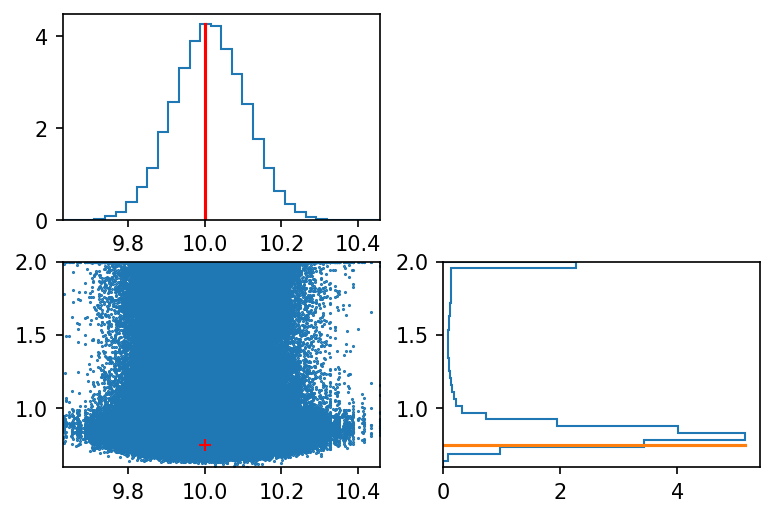

In [12]:
plotSlice(doit.chain[burn:,:], truth, 0,4)

(0.0, 1.25)

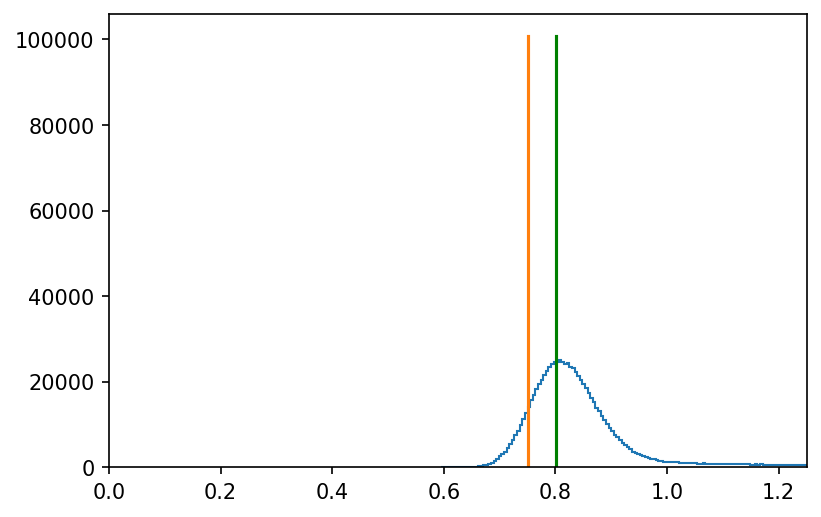

In [13]:
fig, ax = plt.subplots()
hts, bins, ignore = ax.hist(doit.chain[burn:,-2], bins=300, histtype='step');
ax.plot([sig0, sig0], [hts.min(), hts.max()])
ax.plot([sigM0, sigM0], [hts.min(), hts.max()],'g')
ax.set_xlim(0,1.25)

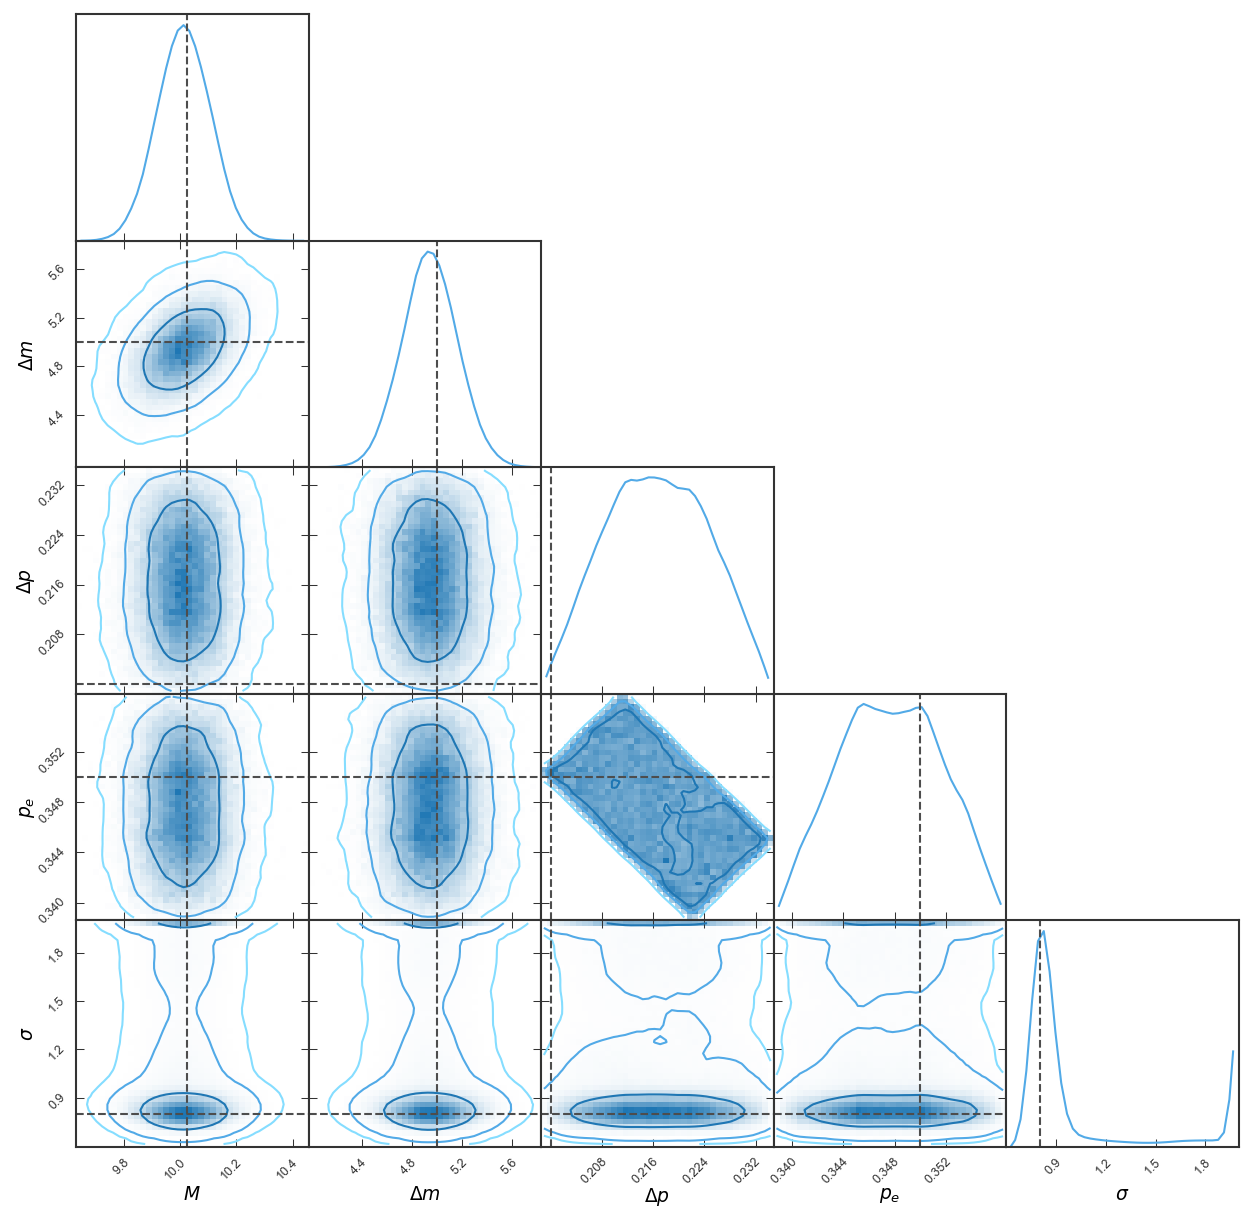

In [14]:
import pygtc
pygtc.plotGTC(chains=[doit.chain[burn:,:-1]],
              paramNames=labs,
              truths=[muM0, dm0, dp0, pe0, sigM0],
              nBins=40,
              smoothingKernel=1,
              nContourLevels=3,
              filledPlots=False,
              plotDensity=True,
              figureSize=10);

In [15]:
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

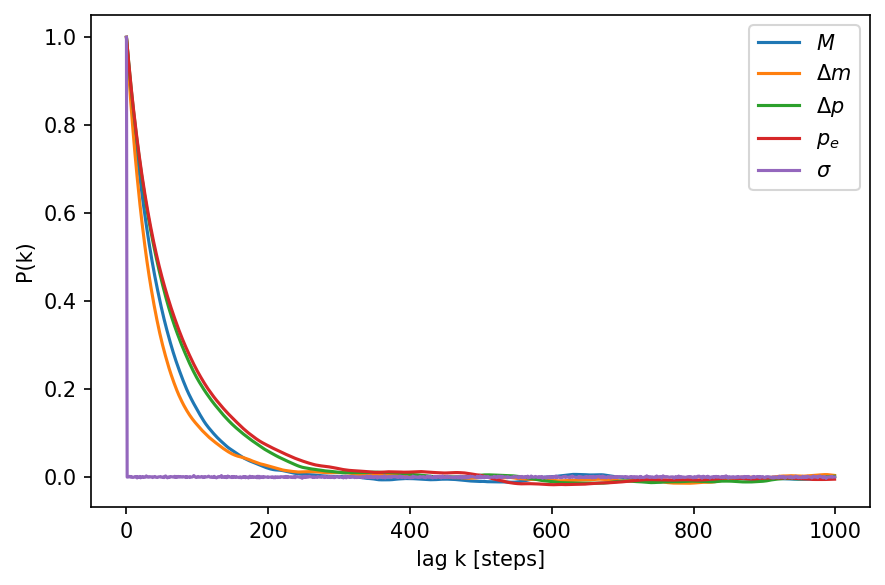

In [16]:
lags = range(0,800)
end = -1
auto(doit.chain[burn:,:], 1000, labs)